# COURSE: PCA and multivariate neural signal processing
## SECTION: Source separation with GED
### VIDEO: Python: Simulated data with and without ZCA
#### Instructor: sincxpress.com

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import copy
import scipy
import scipy.io as sio
from scipy.linalg import sqrtm
from pytopo import topoplotIndie
from filterFGxfun import filterFGx

In [6]:
# toggle for ZCA
dozca = False

In [7]:
## preliminary 

# mat file containing EEG, leadfield and channel locations
matfile = sio.loadmat('MATLAB_data_files//emptyEEG')
lf  = matfile['lf'][0,0]
EEG = matfile['EEG'][0,0]
lfsize = np.shape(lf['Gain'])

EEG['srate']  = 500
EEG['trials'] = 200   # total, 1/2 per condition
EEG['pnts']   = 1000  # time points per trial
EEG['times']  = np.arange(0,EEG['pnts'])/EEG['srate']
EEG['data']   = np.zeros( (int(EEG['nbchan']),int(EEG['pnts']),int(EEG['trials'])) )

In [8]:
## insert activity waveforms into dipole data

dipoleLoc1 = 108

# frequencies of the two dipoles
freq1 = 15

# time point of "stimulus" onset
tidx = np.argmin( np.abs(EEG['times']-np.mean(EEG['times'])) )

# the "innards" of the sine function
omega1 = 2*np.pi*freq1*EEG['times'][tidx:]



# loop over trials
for ti in range(EEG['trials']):
    
    # source waveforms (sine waves with random phase)
    swave1 = np.sin( omega1 + np.random.rand(1)*2*np.pi )
    
    dipole_data = np.random.randn(lfsize[2],EEG['pnts'])/5
    dipole_data[dipoleLoc1,tidx:] += swave1
    
    # project to scalp
    EEG['data'][:,:,ti] = lf['Gain'][:,1,:]@dipole_data



In [10]:
## ZCA

# PCA
tmpdat = np.reshape( EEG['data'],(EEG['nbchan'][0][0],-1),order='F' )
D,V  = np.linalg.eig(np.cov(tmpdat))


# ZCA (check yz*yz'!)
DinvSqrt = sqrtm(np.linalg.inv(np.diag(D)))
yz = V@DinvSqrt@V.T@tmpdat


### replace data with whitened data
if dozca:
    EEG['data'] = np.reshape( yz,(EEG['data'].shape),order='F' )

In [11]:
## GED for spatial filter

covPre = np.zeros( (int(EEG['nbchan']),int(EEG['nbchan'])) )
covPst = np.zeros( (int(EEG['nbchan']),int(EEG['nbchan'])) )


# covariance matrices per trial
for ti in range(EEG['trials']):
    
    # "prestim" covariance
    tdat = EEG['data'][:,:tidx,ti]
    for ci in range(EEG['nbchan'][0][0]):
        tdat -= np.mean(tdat[ci,:])
    covPre += (tdat@tdat.T) / EEG['pnts']
    
    
    # "post-stim" covariance
    tdat = EEG['data'][:,tidx:,ti]
    for ci in range(EEG['nbchan'][0][0]):
        tdat -= np.mean(tdat[ci,:])
    covPst += (tdat@tdat.T) / EEG['pnts']
    

covPre = covPre/ti
covPst = covPst/ti

# GED
evals,evecs = scipy.linalg.eigh(covPst,covPre)
# sort according to eigenvalues
soidx = np.argsort(evals)[::-1]
evals = evals[soidx]
evecs = evecs[:,soidx]


#### compute filter forward models and flip sign
map1 = evecs[:,0].T@covPst # get component
idx  = np.argmax(np.abs(map1)) # find max magnitude
map1 = map1*np.sign(map1[idx])  # possible sign flip



### compute component time series (projections)
cdat = np.zeros( (EEG['pnts'],EEG['trials']) )
for triali in range(EEG['trials']):
    cdat[:,triali] = evecs[:,0].T@EEG['data'][:,:,triali]


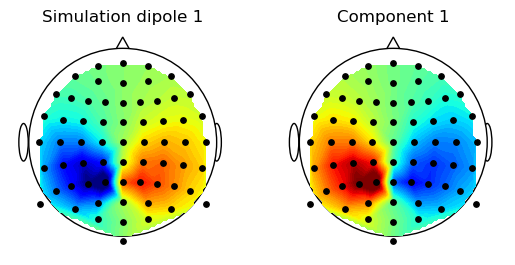

In [12]:
# show the resulting topos

_,axs = plt.subplots(1,2)
topoplotIndie(-lf['Gain'][:,1,dipoleLoc1], EEG['chanlocs'],'Simulation dipole 1',axs[0])
topoplotIndie(map1,EEG['chanlocs'],'Component 1',axs[1])
plt.show()

In [13]:
## standard TF analysis on components

# frequencies in Hz
frex = np.linspace(2,20,20)

# convenient to have component time series data as 2D
comp2d = np.reshape(cdat,(1,-1),order='F')
# comp2d = np.reshape(EEG['data'][[30,46],:,:],(2,int(np.prod(cdat.shape)/2)),order='F')

# initialize time-frequency matrix
ctf = np.zeros( (len(frex),EEG['pnts']) )


# loop over frequencies
for fi in range(len(frex)):
    
    # filter data for both components at this frequency
    filtdat,empvals = filterFGx(comp2d,EEG['srate'],frex[fi],4)
    
    # compute power time series as envelope of Hilbert transform
    tmpm = scipy.signal.hilbert(filtdat)
    asig = np.reshape(tmpm ,(EEG['pnts'],EEG['trials']),order='F')

    # TF power is trial-average power
    ctf[fi,:] = np.mean( np.abs(asig)**2 ,axis=1)
        

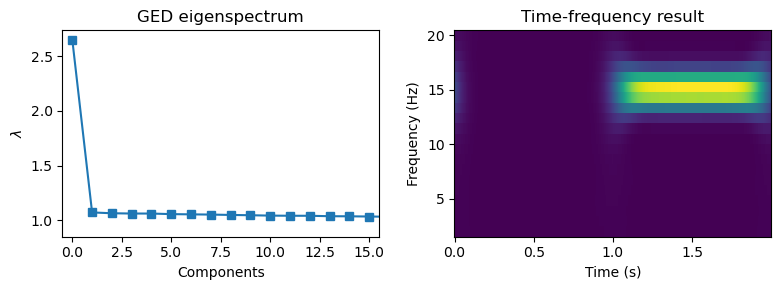

In [14]:
## some plotting

_,axs = plt.subplots(1,2,figsize=(8,3))

axs[0].plot(evals,'s-')
axs[0].set_xlim([-.5,15.5])
axs[0].set_xlabel('Components')
axs[0].set_ylabel('$\lambda$')
axs[0].set_title('GED eigenspectrum')


axs[1].pcolormesh(EEG['times'],frex,ctf)
axs[1].set_title('Time-frequency result')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()